<a href="https://colab.research.google.com/github/SHALISS/IBMjupyterassignment/blob/main/video_to_signal_fft_cwt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required dependencies
!apt-get install -y libgl1-mesa-glx
!pip install opencv-python-headless pywavelets scipy matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Saving sample_video_1.mp4 to sample_video_1 (11).mp4

Processing video...
Analyzing signal...
Generating results...


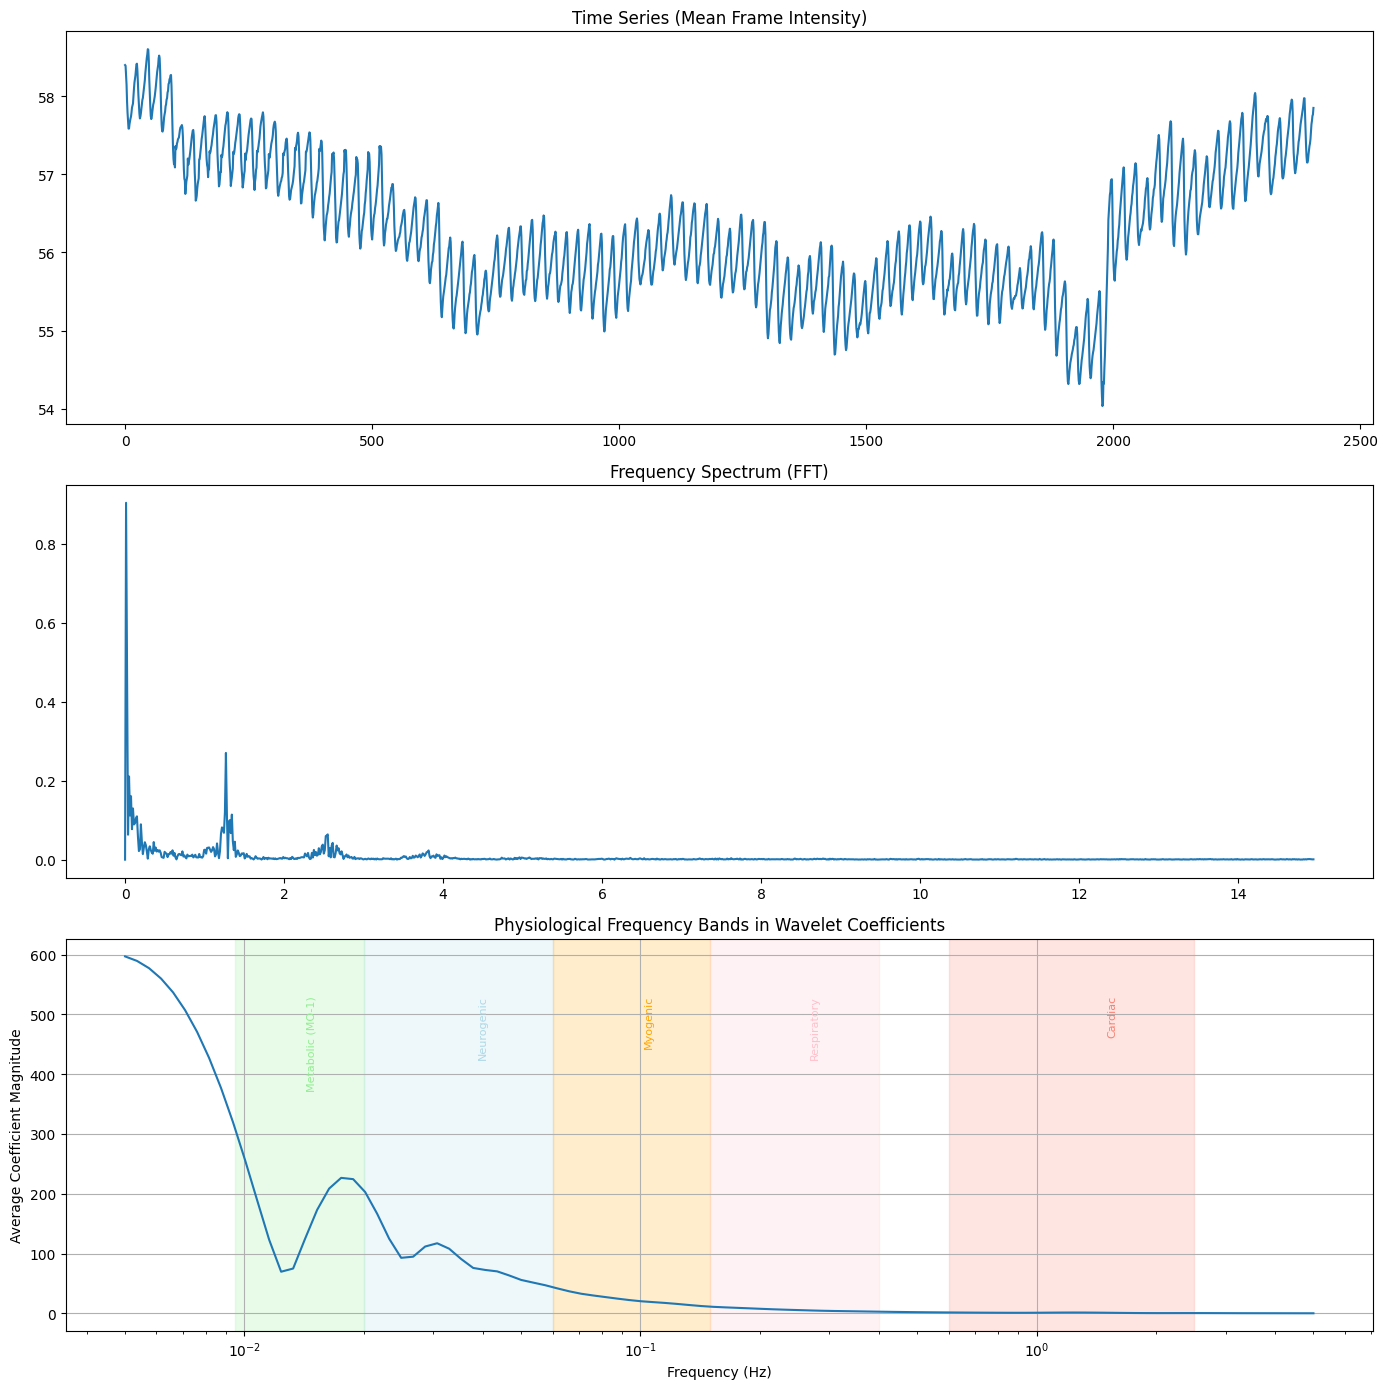

In [ ]:
import cv2
import numpy as np
import pywt
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from google.colab import files

def extract_time_series(video_path):
    """Extract mean intensity time series from video frames"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Could not open video file")

    signal = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        signal.append(np.mean(gray))

    cap.release()
    return np.array(signal)

def analyze_signal(signal, fps):
    """Perform FFT and CWT analysis with physiological band identification"""
    N = len(signal)
    yf = fft(signal - np.mean(signal))
    xf = fftfreq(N, 1/fps)[:N//2]

    scales = np.geomspace(fps/5, fps/0.005, num=100)
    wavelet = 'cmor1.5-1.0'
    sampling_period = 1/fps

    coefs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=sampling_period)

    sort_idx = np.argsort(freqs)
    freqs_sorted = freqs[sort_idx]
    avg_coefs_sorted = np.mean(np.abs(coefs), axis=1)[sort_idx]

    physio_bands = [
        ('Metabolic (MO-1)', 0.0095, 0.02, 'lightgreen'),
        ('Neurogenic', 0.02, 0.06, 'lightblue'),
        ('Myogenic', 0.06, 0.15, 'orange'),
        ('Respiratory', 0.15, 0.4, 'pink'),
        ('Cardiac', 0.6, 2.5, 'salmon')
    ]

    return xf, 2.0/N * np.abs(yf[0:N//2]), freqs_sorted, avg_coefs_sorted, physio_bands

def plot_results(time, signal, xf, yf, freqs, avg_coefs, physio_bands):
    """Generate and save plots with physiological band annotations"""
    fig, ax = plt.subplots(3, 1, figsize=(14, 14))

    # Time series plot
    ax[0].plot(time, signal)
    ax[0].set_title('Time Series (Mean Frame Intensity)')

    # FFT plot
    ax[1].plot(xf, yf)
    ax[1].set_title('Frequency Spectrum (FFT)')

    # CWT plot with bands
    ax[2].semilogx(freqs, avg_coefs)
    ax[2].set_title('Physiological Frequency Bands in Wavelet Coefficients')
    ax[2].set_xlabel('Frequency (Hz)')
    ax[2].set_ylabel('Average Coefficient Magnitude')
    ax[2].grid(True)

    # Add band annotations
    for name, f_low, f_high, color in physio_bands:
        ax[2].axvspan(f_low, f_high, alpha=0.2, color=color)
        ax[2].text((f_low + f_high)/2, 0.85*ax[2].get_ylim()[1], name,
                   rotation=90, va='top', ha='center', fontsize=8, color=color)

    # Save and close figure
    plt.tight_layout()
    plt.savefig('physio_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Main execution flow
uploaded = files.upload()
video_file = list(uploaded.keys())[0]

print("\nProcessing video...")
signal = extract_time_series(video_file)

cap = cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print("Analyzing signal...")
time = np.arange(len(signal))
xf, yf, freqs_sorted, avg_coefs, physio_bands = analyze_signal(signal, fps)

print("Generating results...")
plot_results(time, signal, xf, yf, freqs_sorted, avg_coefs, physio_bands)


In [ ]:
print("Downloading results...")
files.download('physio_analysis.png')
print("Analysis complete! File saved as 'physio_analysis.png'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Analysis complete! File saved as 'physio_analysis.png'
